# 시계열 데이터 처리

데이터 다운로드 : https://www.kaggle.com/c/rossmann-store-sales
* [store.csv]
* [test.csv]
* [train.csv]

# 1. 데이터 소개

- Rossmann은 유럽 7개국에서 3,000개 이상의 약국을 운영하고 있습니다.
- 현재 Rossmann 매장 관리자는 최대 6주 전에 일일 매출을 예측해야 합니다.
- 매장 판매는 프로모션, 경쟁, 학교 및 공휴일, 계절성, 지역 등 다양한 요인의 영향을 받습니다.
- 수천 명의 개별 관리자가 고유한 상황에 따라 판매를 예측하므로 결과의 정확도는 매우 다양할 수 있습니다.

> 목표 : 6주 전에 매출을 예측해야함(결과적으로 현재 기준 6주후까지 매출을 예측해야함)

### 컬럼 의미

- Id : 테스트 세트 내의 (Store, Date) duple을 나타내는 Id
- Store : 각 상점의 고유 ID
- Sales  : 특정 날짜의 매출(이것은 귀하가 예측하는 것입니다)
- Customers  : 특정 날짜의 고객 수
- Open  : 매장이 영업 중인지 여부를 나타내는 표시기: 0 = 영업 종료, 1 = 영업
- StateHoliday : 공휴일을 나타냄. 일반적으로 몇 가지 예외를 제외하고 모든 상점은 공휴일에 문을 닫습니다
    - 모든 학교는 공휴일과 주말에 문을 닫음. a = 공휴일, b = 부활절 휴일, c = 크리스마스, 0 = 없음
- SchoolHoliday : (Store, Date)가 공립학교 폐쇄의 영향을 받았는지 여부를 나타냄
- StoreType : 4가지 상점 모델(a, b, c, d)을 구분함
- Assortment : 구색 수준 설명: a = 기본, b = 추가, c = 확장
- CompetitionDistance : 가장 가까운 경쟁업체 매장까지의 거리(미터)
- CompetitionOpenSince\[Month/Year\] : 가장 가까운 경쟁자가 열린 시간의 대략적인 연도 및 월을 제공함
- Promo  : 매장에서 해당 날짜에 프로모션을 실행하는지 여부를 나타냄
- Promo2 : Promo2는 일부 매장에 대한 지속적이고 연속적인 프로모션. 0 = 매장이 참여하지 않음, 1 = 매장이 참여 중
- Promo2Since\[Year/Week\] : 상점이 Promo2에 참여하기 시작한 연도 및 주를 설명
- PromoInterval : Promo2가 시작되는 연속 간격을 설명하고 판촉이 새로 시작되는 달의 이름을 지정.
    - 예) "2월,5월,8월,11월"은 각 라운드가 해당 매장의 해당 연도의 2월, 5월, 8월, 11월에 시작됨을 의미함

# 2. 시계열 분석을 위한 설치 모듈
- pip install prophet (fbprophet -> prophet 모듈명 변경됨)
- pip install statsmodels  
- (on python 3.9 기준)

### statsmodels 모듈 : 
- 다양한 통계 검정(test)과 추정(estimation)에 필요한 함수와 클래스를 제공하는 모듈
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
##### 주요 함수
- ECDF : 경험적 누적 분포 함수
- seasonal_decompose :
    - 계절성을 분해하여 추세, 계절성, 잔차를 파악할 수 있는 함수
    - 참고 : https://han.gl/IoWnYd
- plot_pacf : 참고 - https://han.gl/NjgNDN
- plot_acf : 참고 - https://signature95.tistory.com/24

### Prophet 모듈
- 페이스북에서 공개한 시계열 예측
- 참고 문서 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

# 3. 실습

In [1]:
# warning 무시
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
# '-' 깨짐 해결 모듈
import matplotlib as mpl

plt.rcParams["font.family"] = "Malgun Gothic"  # For Windows
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8,4)
print(plt.rcParams["font.family"])

# 마이너스 깨짐 해결
mpl.rcParams["axes.unicode_minus"] = False

['Malgun Gothic']


## 1. 필요 모듈 임폴트

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시계열 예측 모델 클래스
from prophet import Prophet

## 2. 데이터 불러오기

In [3]:
train = pd.read_csv("ml_datas/rossmann-store-sales/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

store = pd.read_csv("ml_datas/rossmann-store-sales/store.csv", 
                    low_memory = False)
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [4]:
print("데이터 형태 : ", train.shape)
train.head(5)

데이터 형태 :  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## 3. EDA 및 전처리

### 새로운 컬럼 생성 - 고객당 매출액 계산

In [8]:
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### 누적 분포 그래프
- ECDF :데이터의 분포를 시각적으로 파악할 때 사용
#### [그래프 해석]
- 그래프의 경사가 급격하게 증가하는 부분은 데이터 값이 해당 구간에 집중되어 있다는 것을 나타냄
- 경사가 완만한 부분은 데이터 값이 덜 집중되어 있다는 것을 의미함

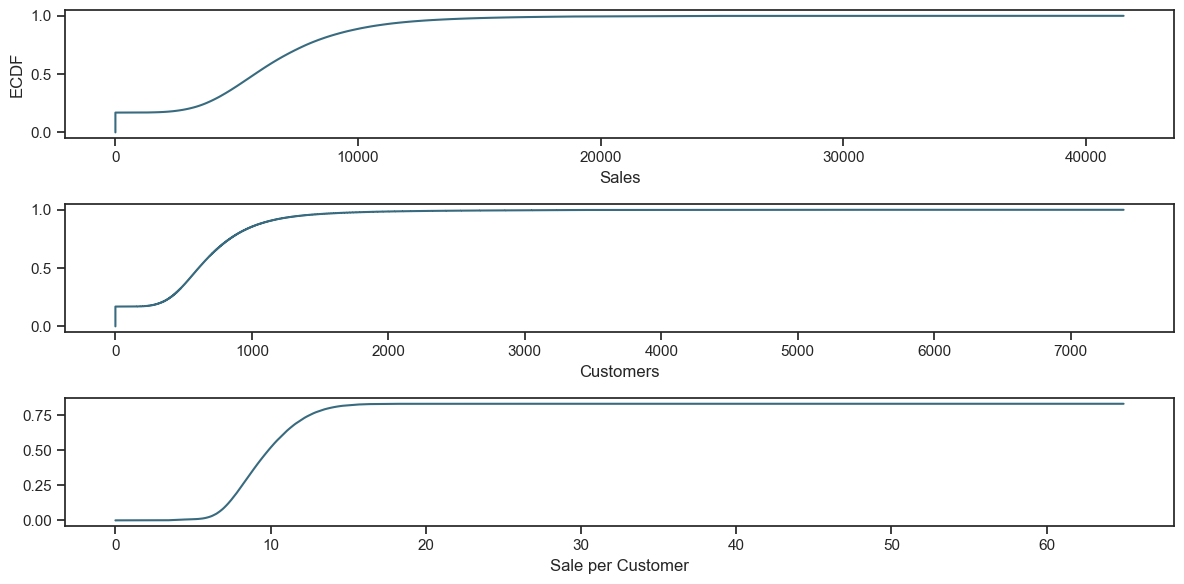

In [9]:
sns.set(style = "ticks")
c = '#386B7F'
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

plt.tight_layout()
plt.show()

- 고객당 매출 : X축이 10~15 사이에 급격하게 변화가 있다는 것을 알 수 있음

### 필터링

- 상점이 오픈을 안했고, 매출액이 0인 경우

In [10]:
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
Date,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,NaN
2015-07-31,876,5,0,0,0,1,0,1,NaN
2015-07-30,292,4,0,0,0,1,0,1,NaN
2015-07-30,876,4,0,0,0,1,0,1,NaN
2015-07-29,292,3,0,0,0,1,0,1,NaN


- 상점이 open은 했고, 매출액이 0인 곳 확인

In [11]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("데이터 형태 : ", zero_sales.shape)
zero_sales.head(5)

데이터 형태 :  (54, 9)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
Date,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,NaN
2015-03-26,674,4,0,0,1,0,0,0,NaN
2015-02-05,699,4,0,0,1,1,0,0,NaN
2014-10-01,708,3,0,0,1,1,0,0,NaN
2014-09-22,357,1,0,0,1,0,0,0,NaN


In [12]:
# 폐업을한 상점 제외시키기
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("데이터 형태 : ", train.shape)

데이터 형태 :  (844338, 9)


In [13]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 결측값 확인하기

In [14]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [15]:
store[pd.isnull(store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


> 결측값 처리

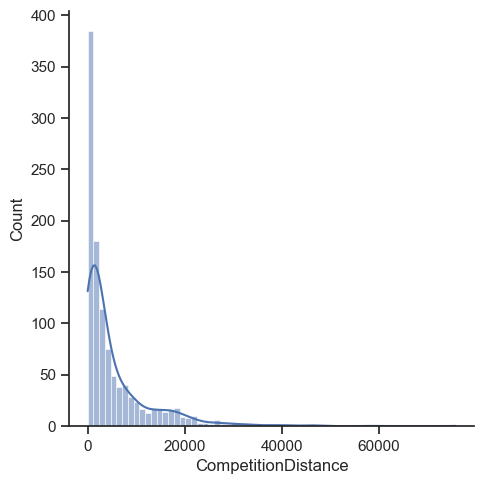

In [16]:
# CompetitionDistance 분포 확인 : 0에 가깝게 몰려있은 것이 확인됨
sns.displot(store['CompetitionDistance'],kde=True)

In [17]:
# 외도가 높고, 이상치가 높으므로 중앙값으로 채우기로 결정함
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [18]:
# _ = store[pd.isnull(store.Promo2SinceWeek)]
# _[_.Promo2 != 0].shape

In [19]:
# 0으로 모두 채워넣기
store.fillna(0, inplace = True)

In [20]:
# 결측값 확인
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

### 데이터 병합

- train, store 데이터 프레임 합치기, Store 기준

In [21]:
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
Date,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,9.702400


In [22]:
train.reset_index(inplace=True)

In [23]:
train.head(2)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
0,2015-07-31,1,5,5263,555,1,1,0,1,9.482883
1,2015-07-31,2,5,6064,625,1,1,0,1,9.702400


In [24]:
store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [25]:
train_store = pd.merge(train, store, on = 'Store', how = 'inner')

print("데이터 형태 : ", train_store.shape)
train_store.head()

데이터 형태 :  (844338, 19)


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2015-07-30,1,4,5020,546,1,1,0,1,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2015-07-29,1,3,4782,523,1,1,0,1,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2015-07-28,1,2,5011,560,1,1,0,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,2015-07-27,1,1,6102,612,1,1,0,1,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### 데이터 시각화 해보기

#### 가게 유형

In [26]:
# storetype 별로 매출 확인
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [27]:
# storetype 별로 고객수, 매출 확인
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


#### 가게 유형별 매출액 월별 추이

In [28]:
train_store.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2015-07-30,1,4,5020,546,1,1,0,1,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2015-07-29,1,3,4782,523,1,1,0,1,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2015-07-28,1,2,5011,560,1,1,0,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,2015-07-27,1,1,6102,612,1,1,0,1,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


#### 날짜 데이터를 년, 월, 일 컬럼으로 구분하기

In [29]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       844338 non-null  datetime64[ns]
 1   Store                      844338 non-null  int64         
 2   DayOfWeek                  844338 non-null  int64         
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   SalePerCustomer            844338 non-null  float64       
 10  StoreType                  844338 non-null  object        
 11  Assortment                 844338 non-null  object  

In [30]:
# 'Date' 컬럼을 년, 월, 일로 분리하여 새로운 컬럼 추가
# Date가 문자열인경우
# train_store[['Year', 'Month', 'Day']] = train_store['Date'].str.split('-', expand=True)

# Date가 datetime 타입인경우
train_store['Year'] = train_store['Date'].dt.year
train_store['Month'] = train_store['Date'].dt.month
train_store['Day'] = train_store['Date'].dt.day
train_store['WeekOfYear'] = train_store['Date'].dt.isocalendar().week

In [31]:
train_store

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,2015-07-31,1,5,5263,555,1,1,0,1,9.482883,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
1,2015-07-30,1,4,5020,546,1,1,0,1,9.194139,...,9.0,2008.0,0,0.0,0.0,0,2015,7,30,31
2,2015-07-29,1,3,4782,523,1,1,0,1,9.143403,...,9.0,2008.0,0,0.0,0.0,0,2015,7,29,31
3,2015-07-28,1,2,5011,560,1,1,0,1,8.948214,...,9.0,2008.0,0,0.0,0.0,0,2015,7,28,31
4,2015-07-27,1,1,6102,612,1,1,0,1,9.970588,...,9.0,2008.0,0,0.0,0.0,0,2015,7,27,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,2013-01-07,292,1,9291,1002,1,1,0,0,9.272455,...,6.0,2009.0,0,0.0,0.0,0,2013,1,7,2
844334,2013-01-05,292,6,2748,340,1,0,0,0,8.082353,...,6.0,2009.0,0,0.0,0.0,0,2013,1,5,1
844335,2013-01-04,292,5,4202,560,1,0,0,1,7.503571,...,6.0,2009.0,0,0.0,0.0,0,2013,1,4,1
844336,2013-01-03,292,4,4580,662,1,0,0,1,6.918429,...,6.0,2009.0,0,0.0,0.0,0,2013,1,3,1


### 가게 유형별 매출액의 월별 추이

#### catplot()
- row, col을 기분으로 조합을 해서 차트를 그려줌

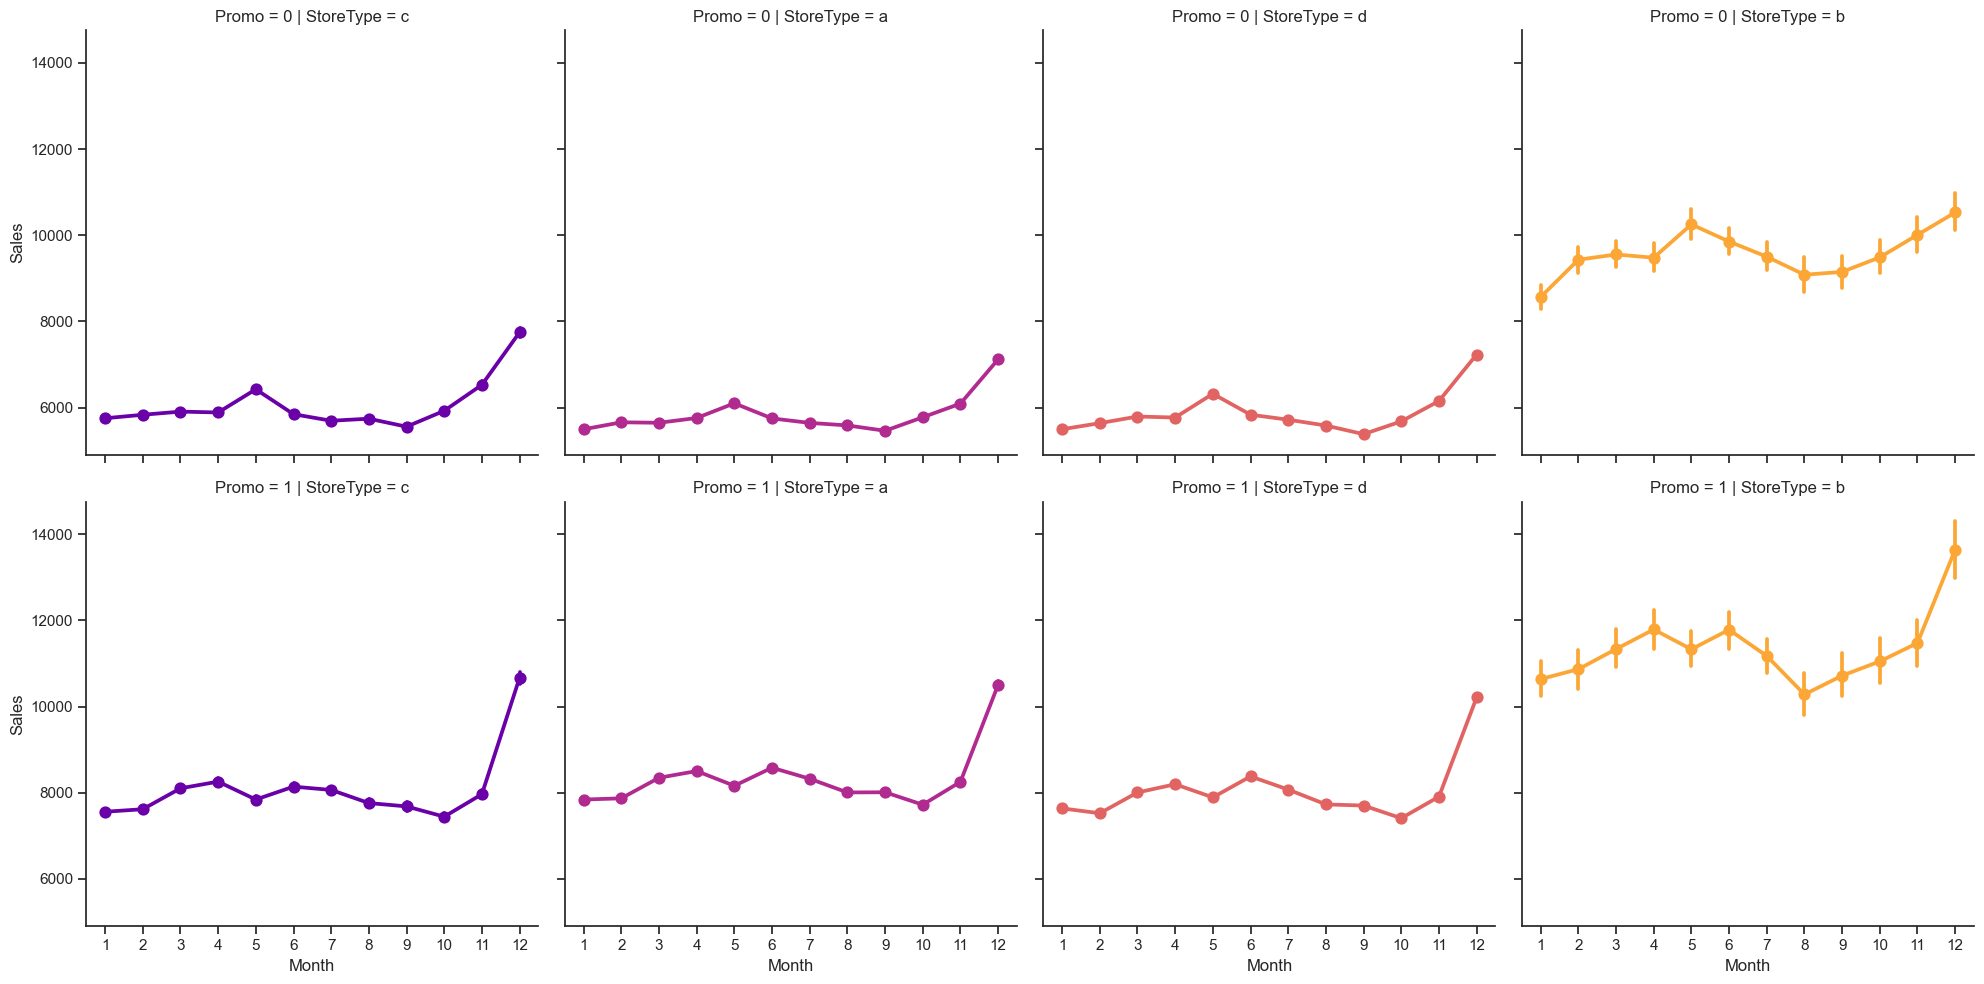

In [32]:
# sns.factorplot() -> sns.catplot() 로 변경됨
sns.catplot(data=train_store, x='Month', y='Sales',
            hue='StoreType',
            col='StoreType', # per store type in cols
            row='Promo', # per promo in the store in rows
            palette='plasma',
            color='c',
            kind='point') 
plt.tight_layout()
plt.show()

##### [차트 해석]
- storeTypeb가 프로모션 상관없이 매출액이 제일 많음
- 프로모션이 있을때 매출액이 증가한다는 것을 알 수 있음
- 4분기에 매출액이 증가하고, 프로모션을 했을 때 더 증가한다는 것을 알 수 있음

#### 가게 유형별 고객 수 월별 추이

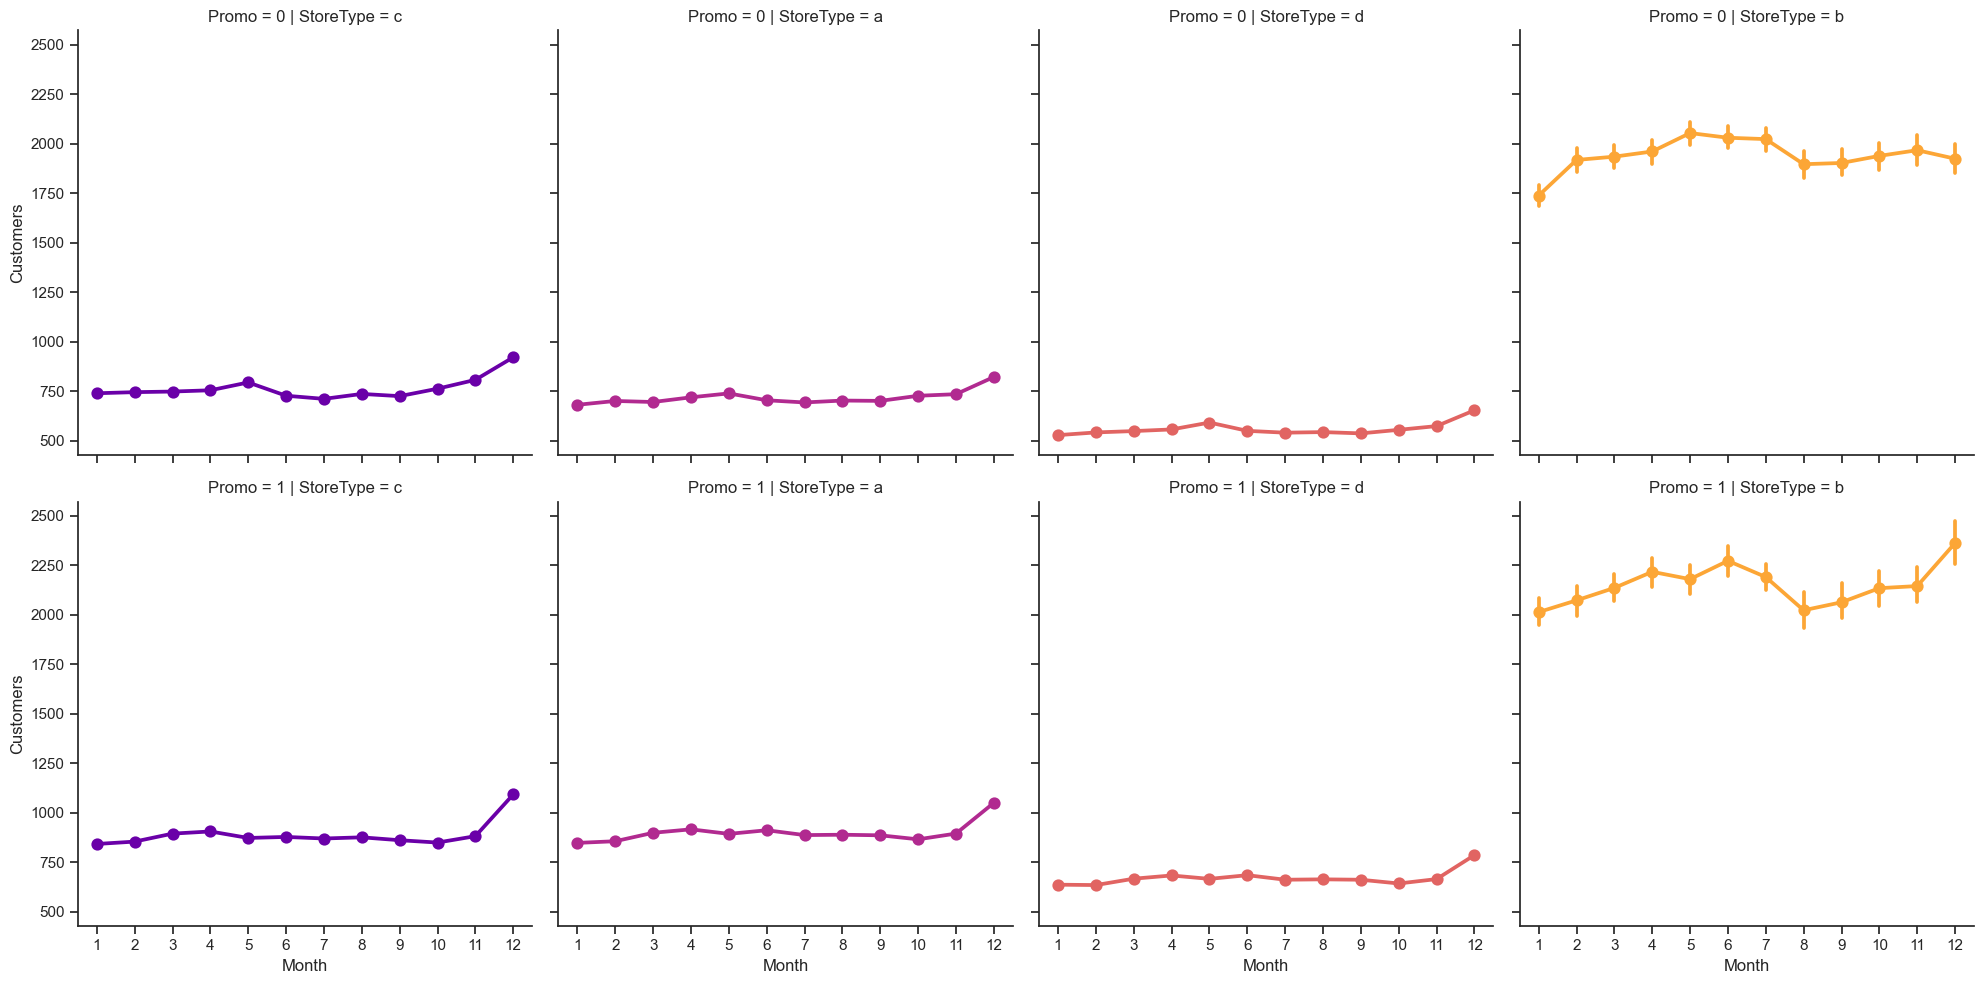

In [33]:
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
            hue = 'StoreType',
            col = 'StoreType',
            row = 'Promo',
            palette = 'plasma',
            color = c,
            kind='point'
         ) 
plt.tight_layout()
plt.show()

#### 가게 유형별 고객 당 매출액 월별 추이

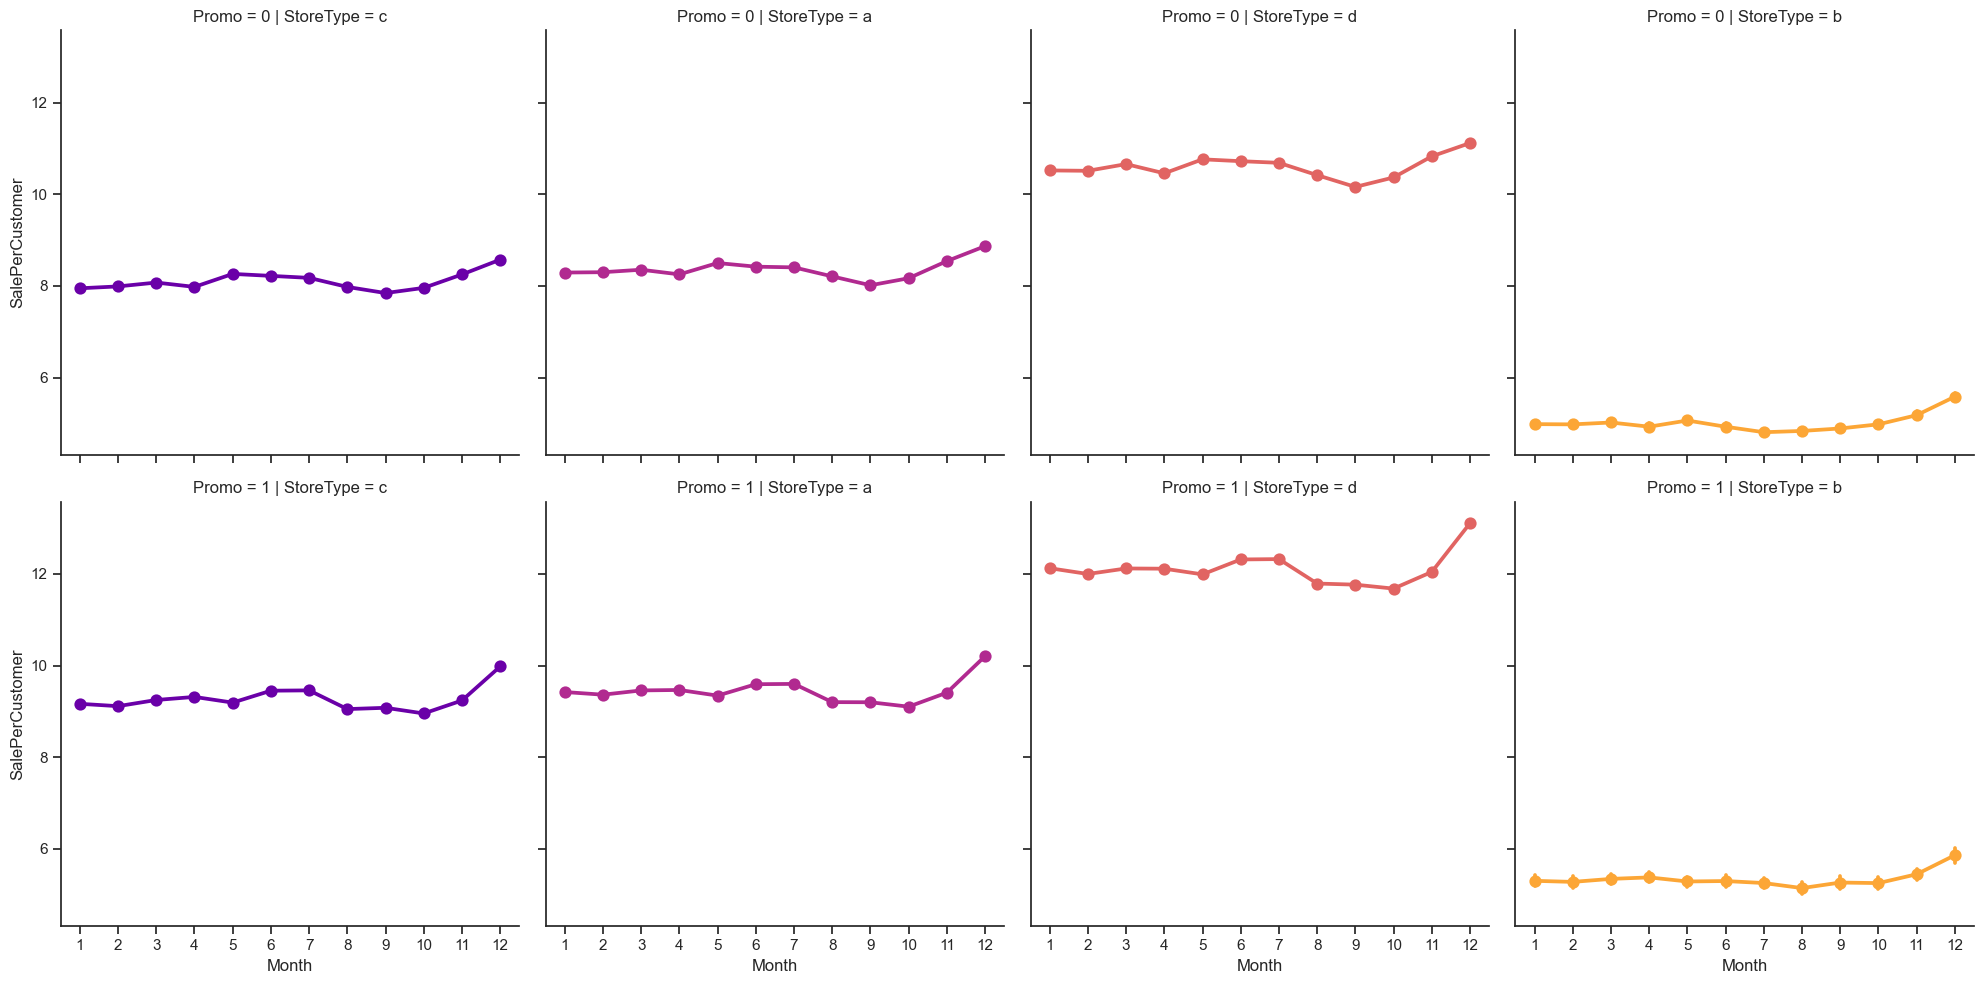

In [34]:
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
            hue = 'StoreType',            
            col = 'StoreType', # per store type in cols
            row = 'Promo', # per promo in the store in rows
            palette = 'plasma',
            color = c,
            kind='point'        
           ) 
plt.tight_layout()
plt.show()

- b는 프로모션 효과가 없는 것으로 해석됨

#### 가게 유형별 매출액 주별 추이

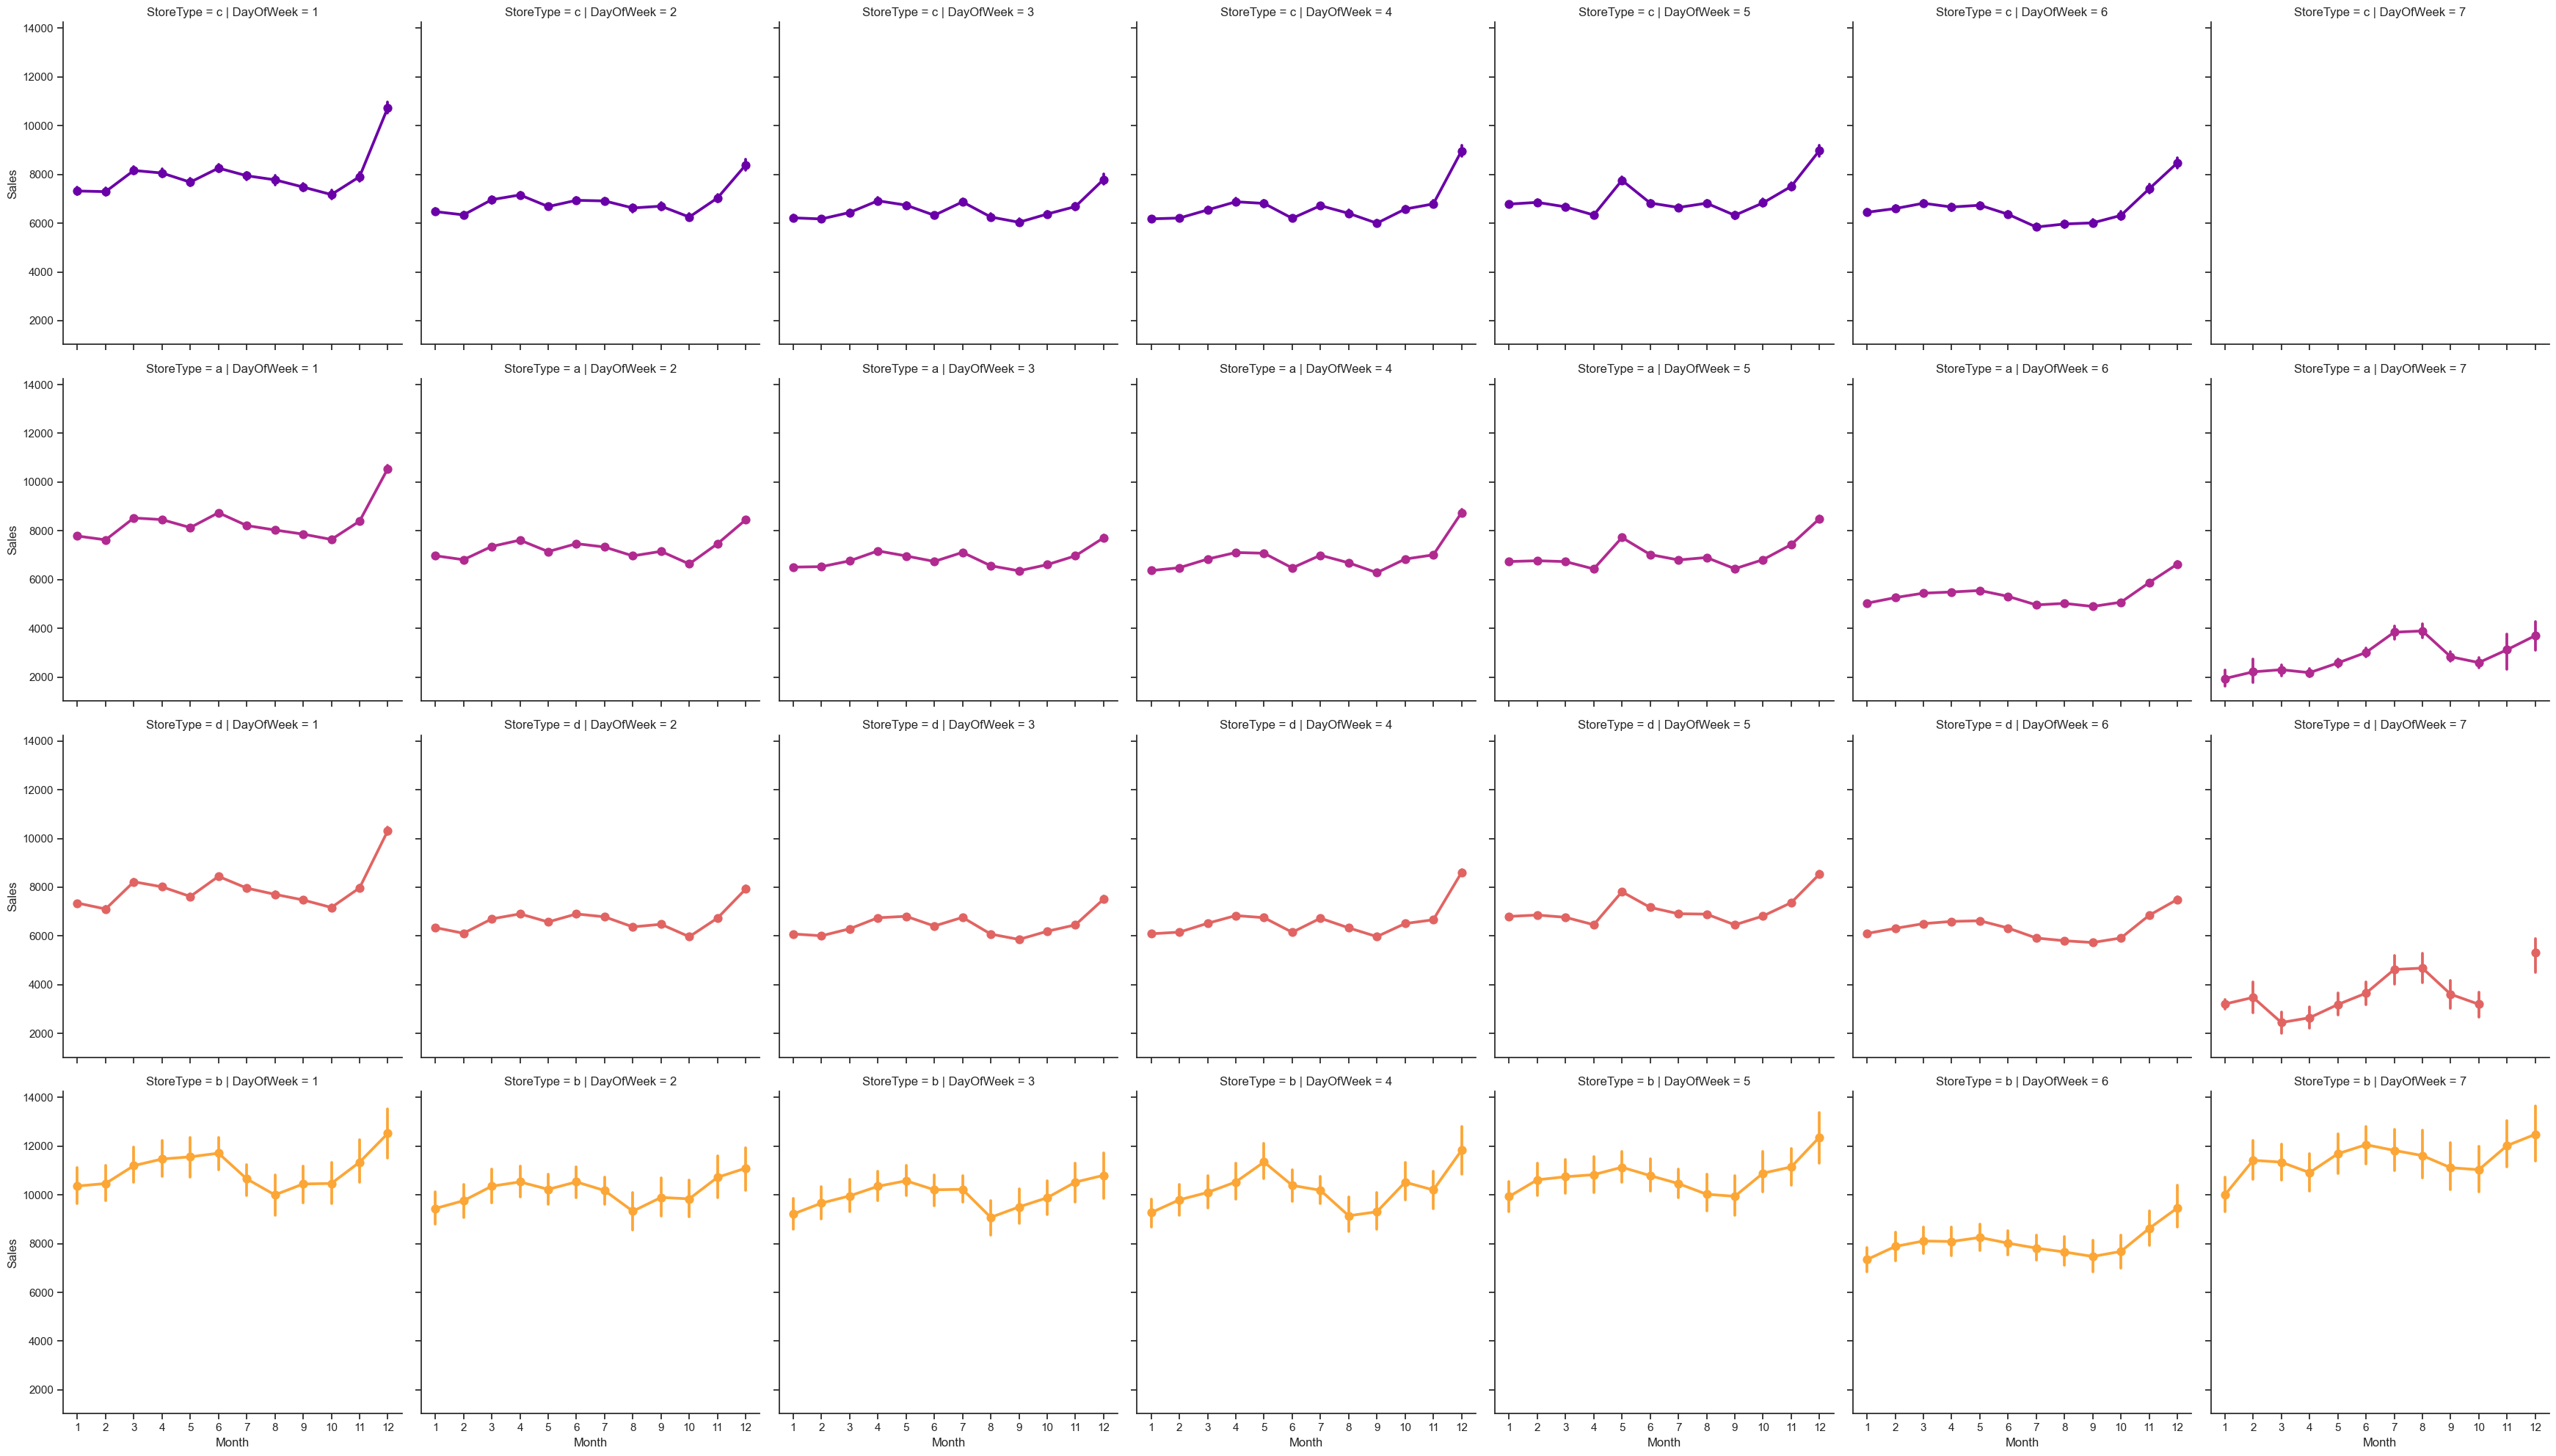

In [35]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
            hue = 'StoreType',
            row = 'StoreType', # per store type in rows
            col = 'DayOfWeek', # per store type in cols
            palette = 'plasma',
            color = c,
            kind='point' 
            ) 
plt.tight_layout()
plt.show()

##### [차트 해석]
- storetype c는 요일에 영향을 받지 않는 물건을 판매함
- storetype a는 주말로 갈 수 록 매출이 적어짐
- storetype d는 주말이 매출이 적어짐
- storetype b는 상대적으로 다른 타입에 비해 매출이 높은 편인데 토요일만 비슷함

#### 일요일에 문을 여는 가게들
- DayOfWeek 7 -> 일요일

In [36]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

In [37]:
# 총 경쟁 개월수
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

# 프로모션 오픈 개월수
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

In [38]:
# null 값은 0으로 채우기
train_store.fillna(0, inplace = True)

# 각 StoreType을 기준으로 평균 확인하기
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### 상관관계 확인

#### 히트맵

In [39]:
num_cols = train_store.select_dtypes(include=np.number).columns
num_cols

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'SalePerCustomer', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [40]:
corr_all = train_store[num_cols].drop('Open', axis = 1).corr()

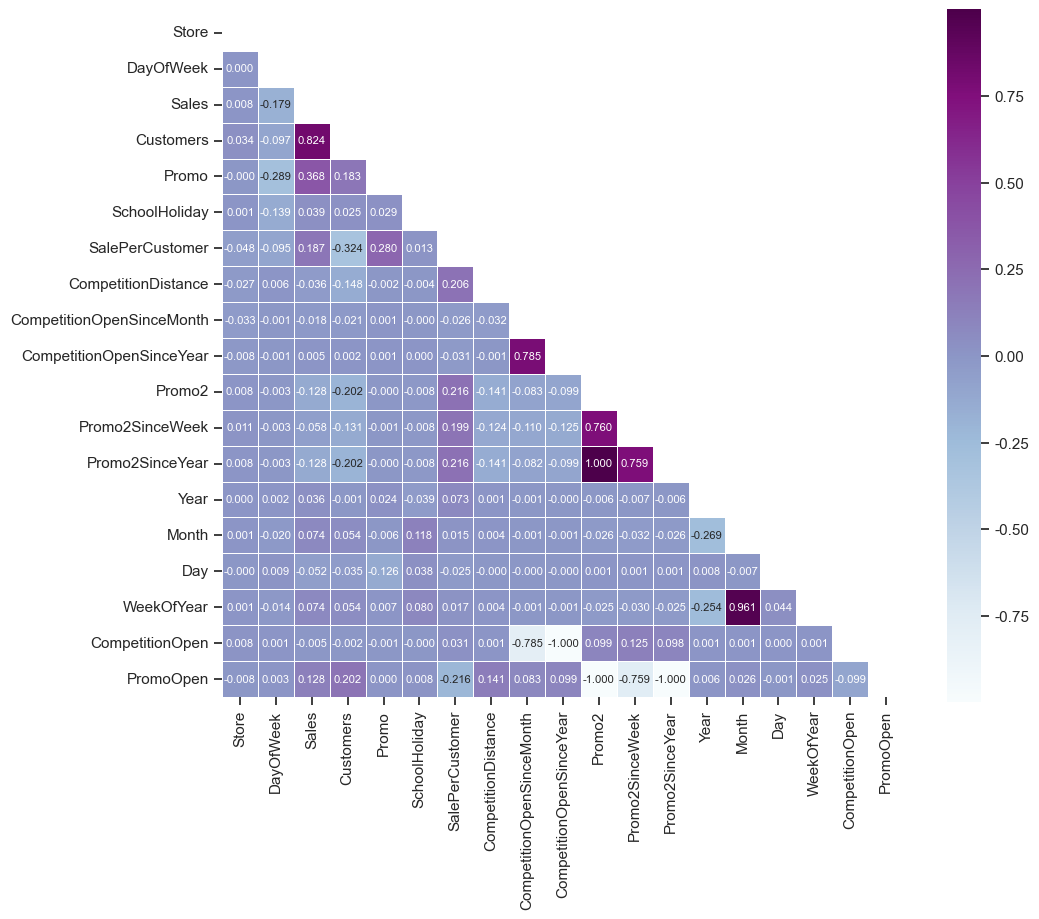

In [41]:
mask = np.zeros_like(corr_all, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_all, mask = mask,
            square = True, 
            annot=True,
            annot_kws={"size": 8},
            fmt=".3f", 
            linewidths = .5, 
            ax = ax, 
            cmap = "BuPu")  
    
plt.show()

#### 프로모션 조합별 매출액 주별 추이

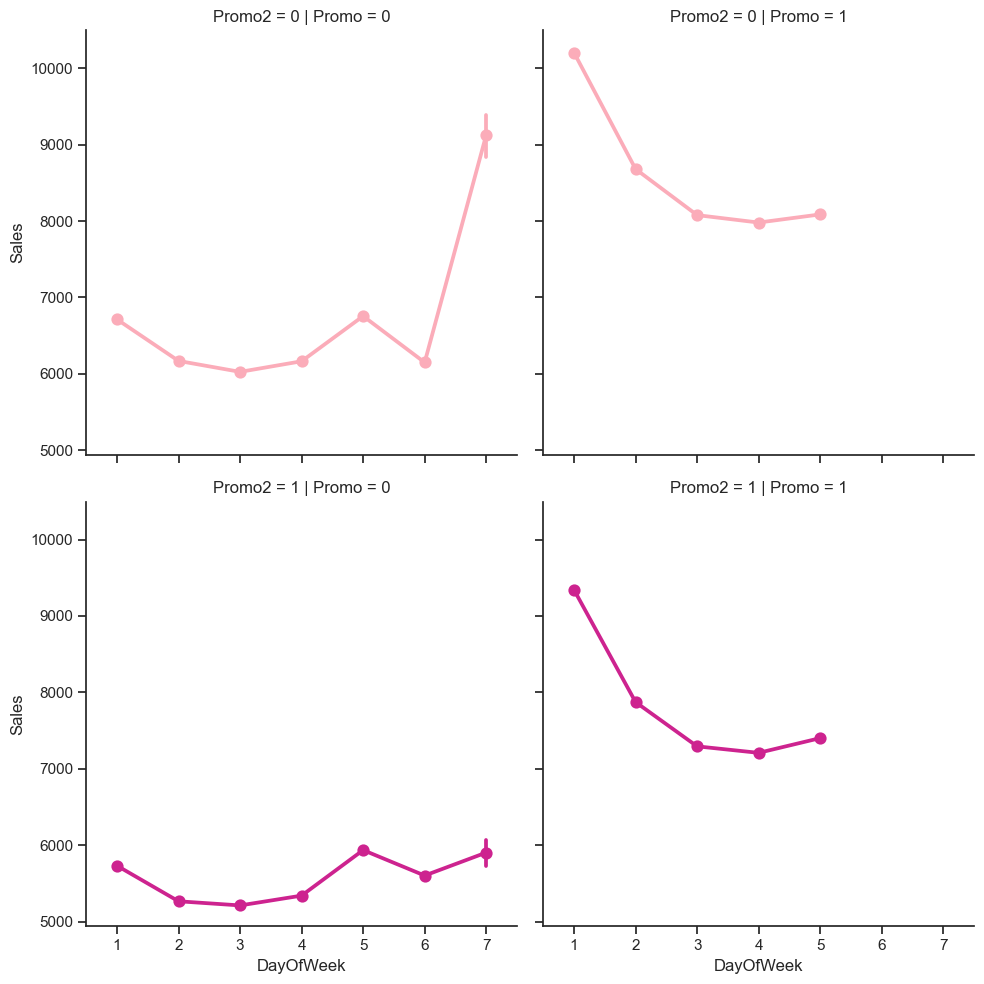

In [42]:
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
            col = 'Promo', 
            row = 'Promo2',
            hue = 'Promo2',
            palette = 'RdPu',
            kind='point'             
           ) 
plt.tight_layout()
plt.show()

## 계절성, 추세, 자기상관 기반 시계열 분석

### 계절성에 따른 매출액 특징

In [43]:
train

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
0,2015-07-31,1,5,5263,555,1,1,0,1,9.482883
1,2015-07-31,2,5,6064,625,1,1,0,1,9.702400
2,2015-07-31,3,5,8314,821,1,1,0,1,10.126675
3,2015-07-31,4,5,13995,1498,1,1,0,1,9.342457
4,2015-07-31,5,5,4822,559,1,1,0,1,8.626118
...,...,...,...,...,...,...,...,...,...,...
844333,2013-01-01,682,2,3375,566,1,0,a,1,5.962898
844334,2013-01-01,733,2,10765,2377,1,0,a,1,4.528818
844335,2013-01-01,769,2,5035,1248,1,0,a,1,4.034455
844336,2013-01-01,948,2,4491,1039,1,0,a,1,4.322425


In [44]:
# Date 컬름을 index로 변경
train = train.set_index('Date')
train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
Date,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,8.626118
...,...,...,...,...,...,...,...,...,...
2013-01-01,682,2,3375,566,1,0,a,1,5.962898
2013-01-01,733,2,10765,2377,1,0,a,1,4.528818
2013-01-01,769,2,5035,1248,1,0,a,1,4.034455


In [ ]:
train['Sales'] = train['Sales'] * 1.0

In [61]:
train['Store'][train['Store']==2].value_counts()

Store
2    784
Name: count, dtype: int64

In [51]:
sales_a = train[train.Store == 2]['Sales']

In [53]:
sales_a.count()

784

In [54]:
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_b.count()

942

In [55]:
sales_c = train[train.Store == 1]['Sales']
sales_c.count()

781

In [75]:
sales_d = train[train.Store == 13]['Sales']
sales_d.count()

621

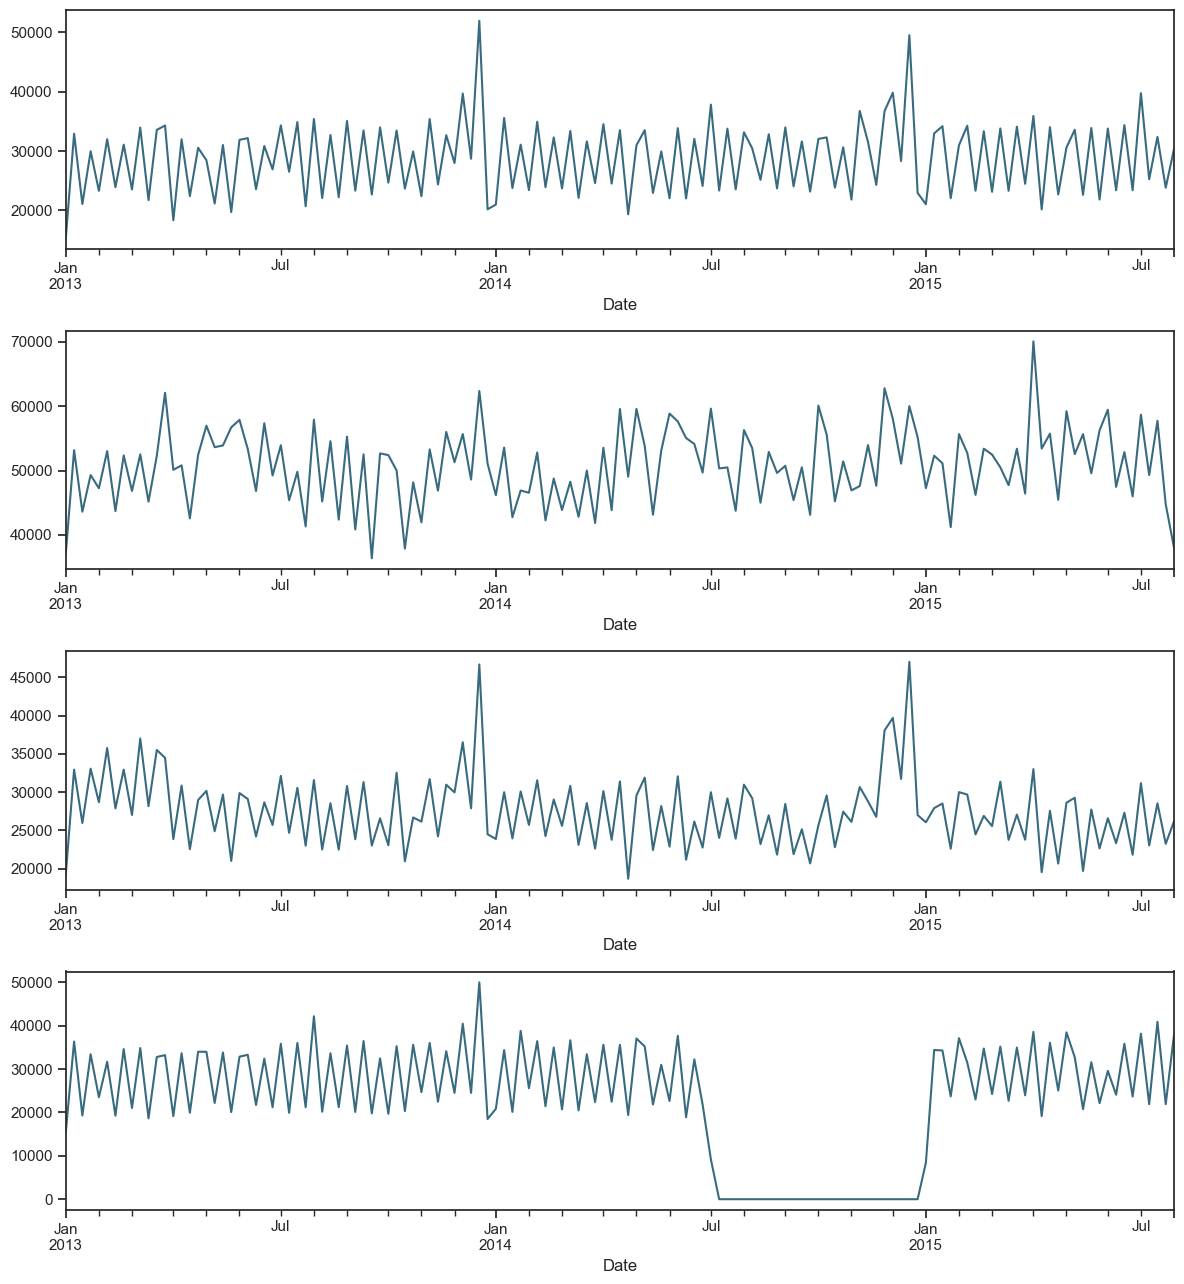

In [76]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# W : 주간 샘플링
# M : 월간 샘플링
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)
plt.tight_layout()
plt.show()

### 연간 매출액 특징
#### 계절성을 제거하고 보기
- 데이터의 추세와 잔차를 더 잘 이해하고 모델링할 수 있음
- 사용함수 : seasonal_decompose()
- 시계열 데이터의 계절성을 분해하여 추세(Trend), 계절성(Seasonal), 잔차(Residual)로 분리하는 함수
- 전달인자 model :
    - "additive" 모델은 선형적인 분해를 가정
    - "multiplicative" 모델은 비선형적인 분해를 가정

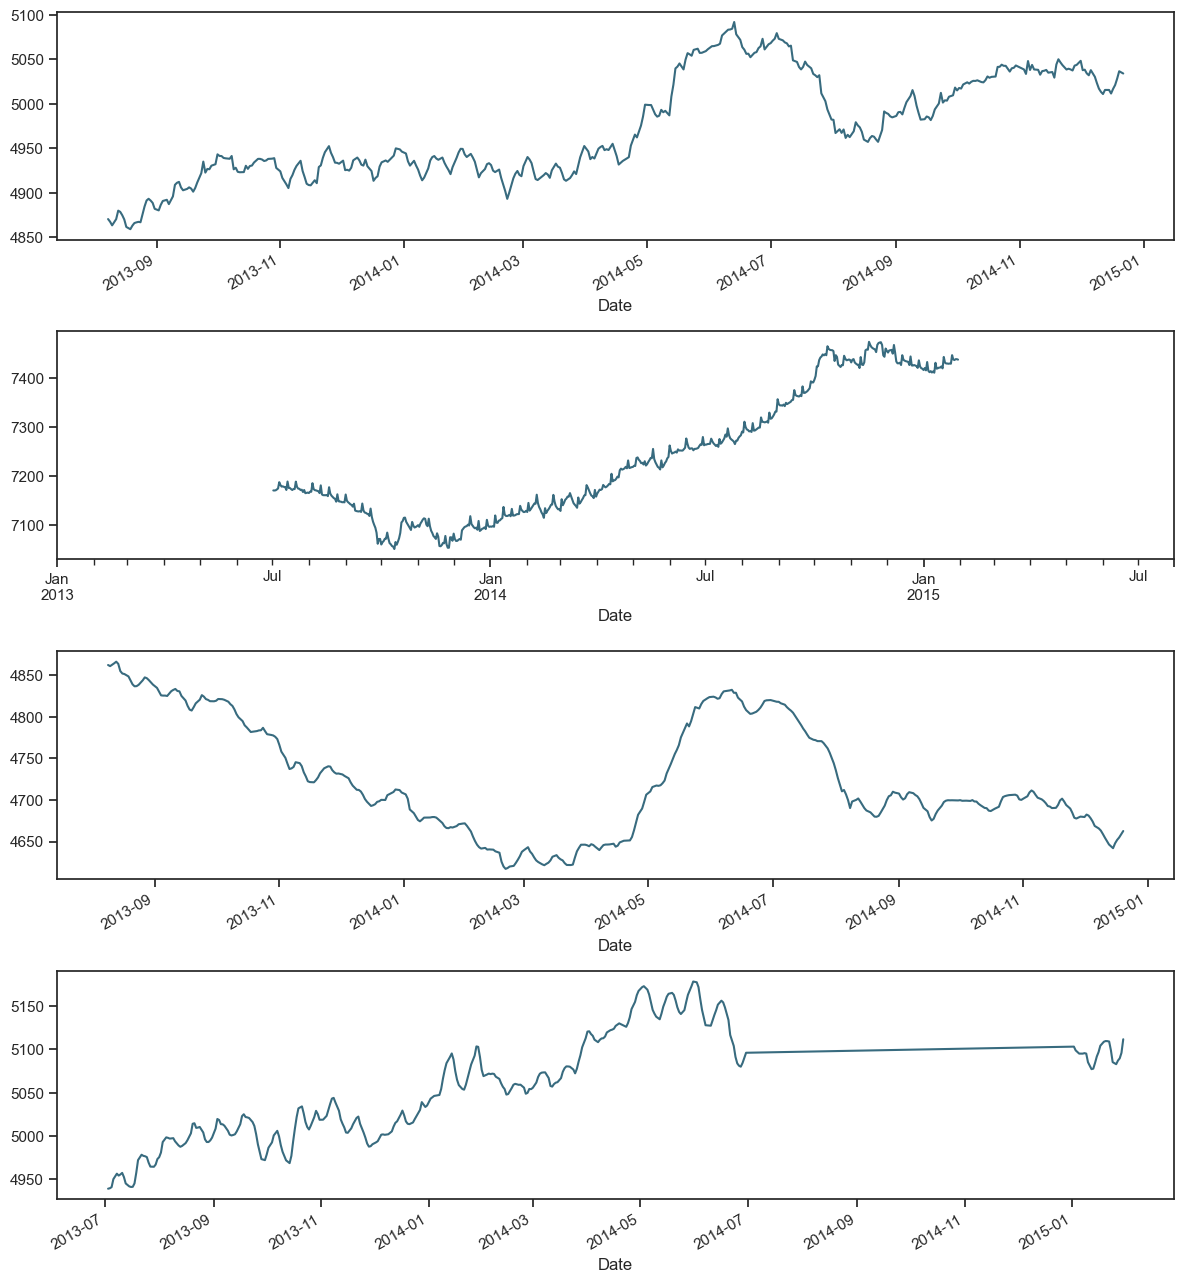

In [92]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))


decomposition_a = seasonal_decompose(sales_a, model = 'additive', period  = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period  = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period  = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

# data 갯수가 부족해서 period 값을 300으로 설정, 
decomposition_d = seasonal_decompose(sales_d, model = 'additive',  period  = 300)
decomposition_d.trend.plot(color = c, ax = ax4)

plt.tight_layout()
plt.show()

### 자기상관 기반 매출액 추세
- 과거의 데이터와 현재의 데이터와 어떤 상관성이 있는지 알아보기
- leg가 파란색 선(오차범위) 안에 모여있으면 상관성이 좋은 데이터로 볼 수 있음

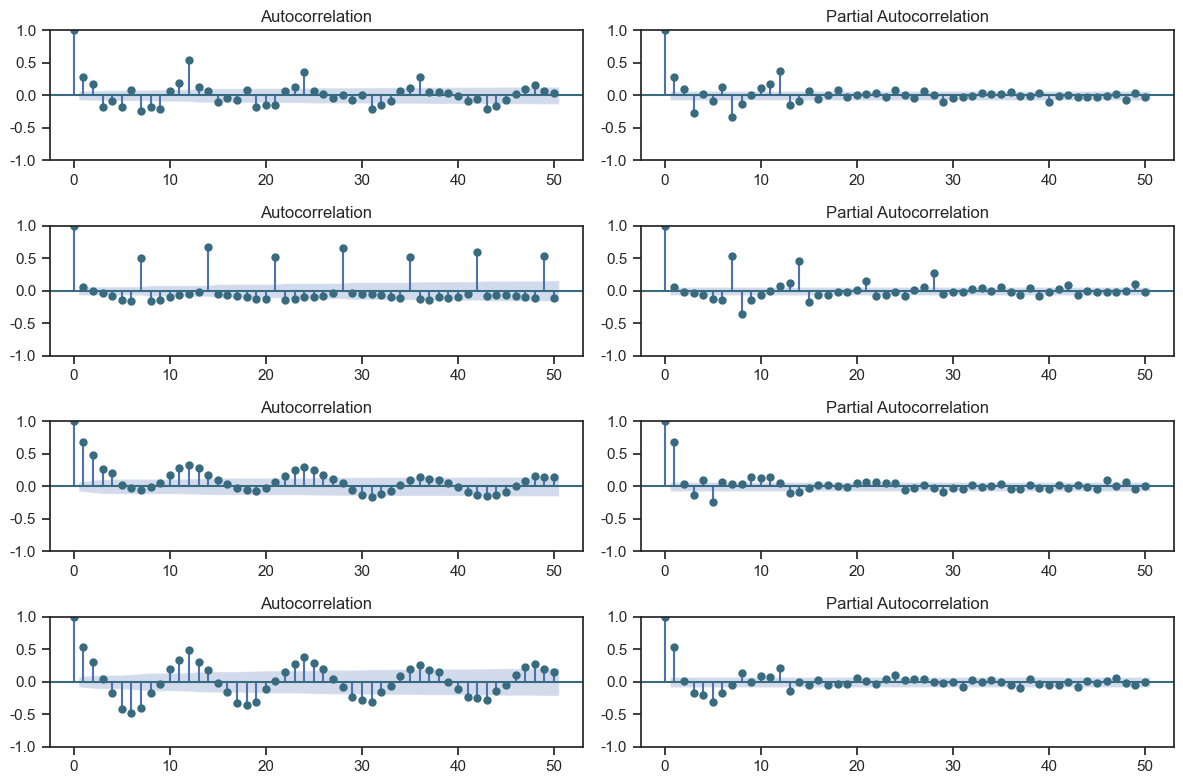

In [99]:
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.tight_layout()
plt.show()

## Prophet 활용한 매출 예측

> 오픈 가게에 대한 6주간의 매출액 예측

In [101]:
df = pd.read_csv("ml_datas/rossmann-store-sales/train.csv",  
                    low_memory = False)

df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [102]:
# Prophet 에서는 모든 컬럼이 이름을 가져야 한다
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


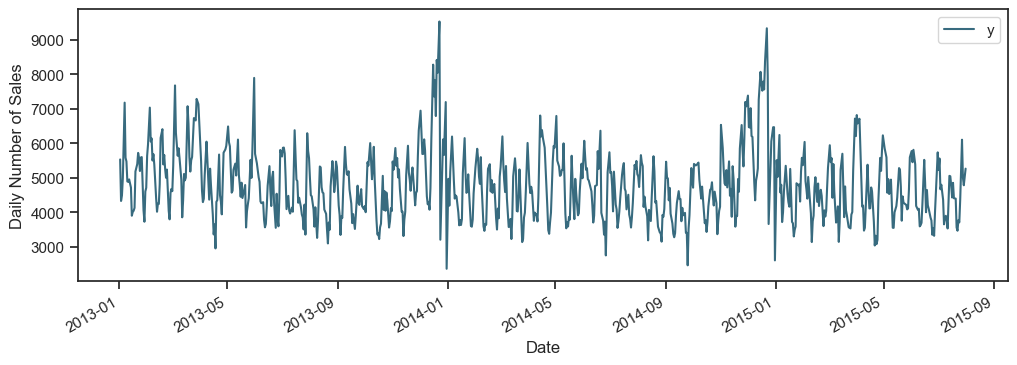

In [103]:
# 일일 매출 그래프
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

> 공휴일인 날짜 추출

In [104]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04
...,...,...
163440,school_holiday,2013-01-01
163441,school_holiday,2013-01-01
163442,school_holiday,2013-01-01
163443,school_holiday,2013-01-01


#### 모델링 및 예측

#### Prophet() 시계열 학습기의 하이퍼 파라메터


In [105]:
# Interval width : 95% (기본값 : 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# 6주 간의 미래 데이터 만듬(6*7 = 42일) 간의 미래 데이터 예측
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("첫번째 주 예측 : ")
future_dates.tail(7)

12:53:51 - cmdstanpy - INFO - Chain [1] start processing
12:53:52 - cmdstanpy - INFO - Chain [1] done processing


첫번째 주 예측 : 


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [106]:
forecast = my_model.predict(future_dates)

# 마지막 주 예측
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4091.717287,2574.378766,5841.411613
817,2015-09-06,4086.645857,2429.414079,5644.564697
818,2015-09-07,4161.313204,2504.057232,5781.957985
819,2015-09-08,3663.680110,2034.603232,5394.049528
820,2015-09-09,3550.467989,1900.616749,5099.981752
821,2015-09-10,3461.993095,1757.070844,5075.545570
822,2015-09-11,3716.673879,2135.391606,5316.961954


#### 시각화

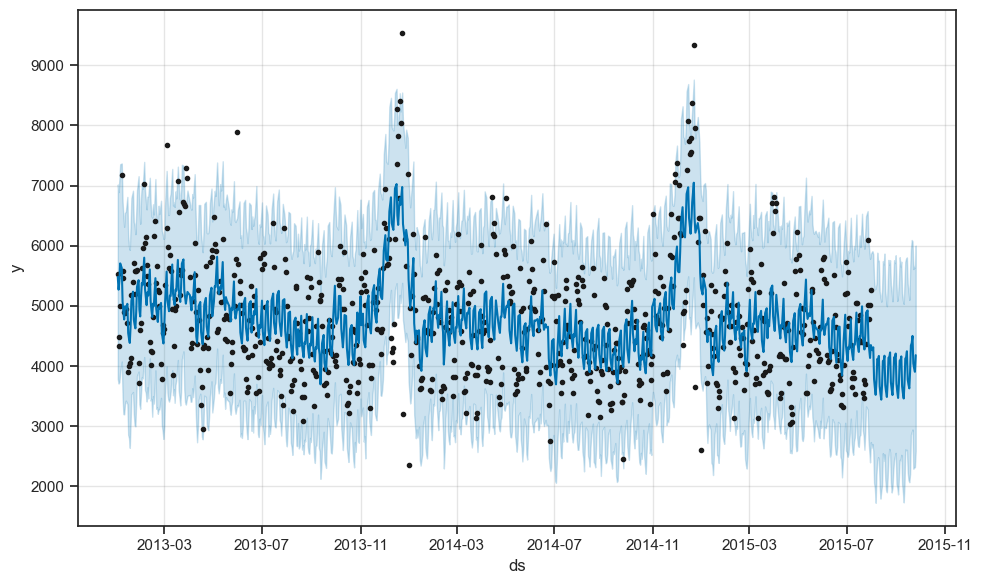

In [138]:
# 파란색 선이 예측값, 검은색 점이 실제 데이터임
my_model.plot(forecast);

> 시계열 데이터의 주요 구성 요소를 시각화
- 성분의 플롯을 분석하면 데이터의 추세, 주기성, 휴일 이벤트 등의 패턴 파악
- Trend (트렌드): 시계열 데이터의 장기적인 증가 또는 감소 경향을 보여줌.
    - 추세 플롯을 통해 데이터가 어떻게 변화하는지와 장기적인 패턴을 파악할 수 있음
- Seasonality (계절성): 시계열 데이터의 주기적인 패턴을 시각화함
    -  계절성 플롯은 연간, 분기별, 월간 또는 주간과 같은 주기에 따른 데이터의 패턴을 보여줌
    -  계절성 플롯을 통해 데이터가 특정 시간대에서 어떤 패턴을 가지는지 확인할 수 있음
- Holidays (휴일): 특정 휴일 또는 이벤트와 관련된 데이터의 패턴을 시각화함
    - 휴일 플롯은 휴일이나 이벤트가 시계열 데이터에 어떤 영향을 미치는지를 확인할 수 있음

- plot_components : 모델의 주요 구성성분으로 시각화를 해줌

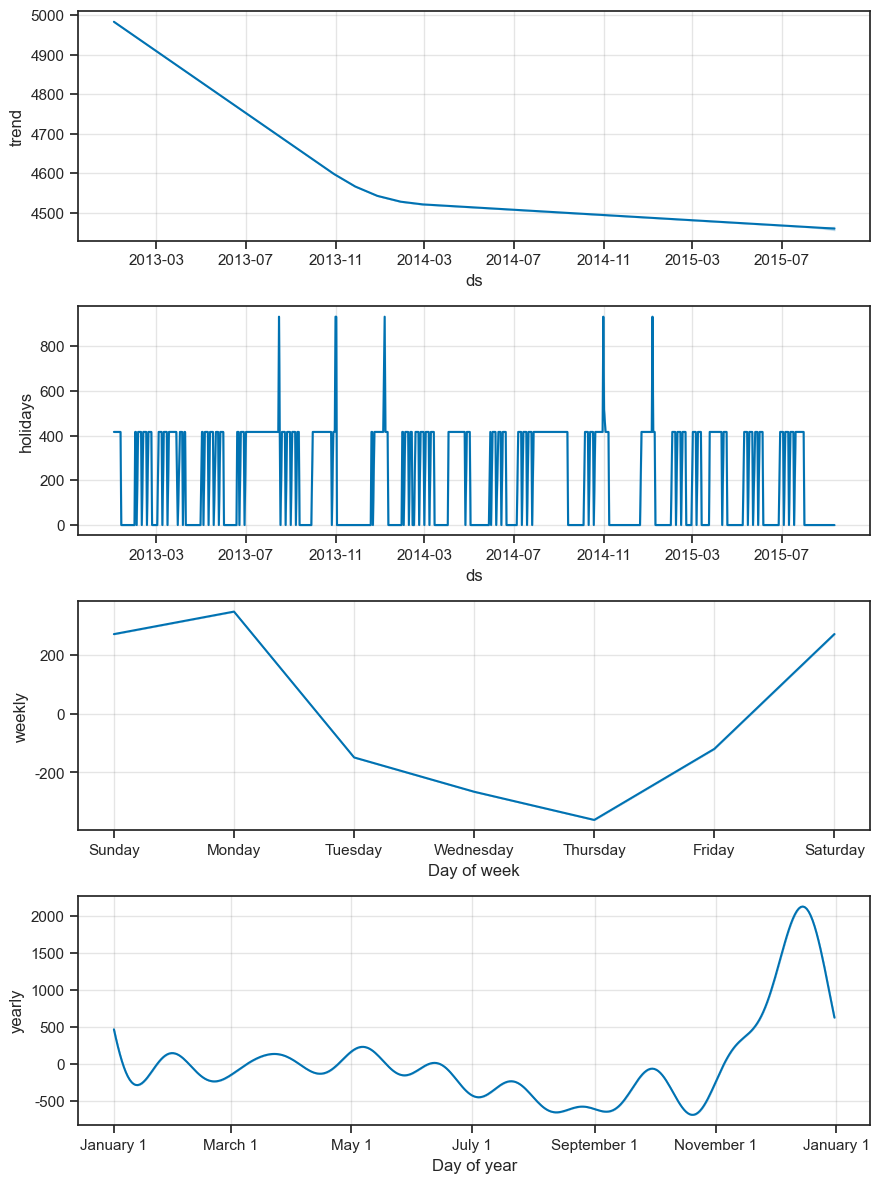

In [107]:
my_model.plot_components(forecast);